#### Харламова Альфия, МЖД 191

### Ссылка на giigle slides с презентацией: https://docs.google.com/presentation/d/19yByzFFLXJsmYW_njSFMw6FBbUEopSLEmk_cvZsw97w/edit?usp=sharing

In [323]:
import requests
from bs4 import BeautifulSoup
from time import sleep
from itertools import groupby
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from rake_nltk import Metric, Rake
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
from natasha import MorphVocab, Doc, NewsNERTagger, NewsMorphTagger, NewsEmbedding, Segmenter
from collections import Counter
import re, os
from stop_words import get_stop_words

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)
morph_tagger = NewsMorphTagger(emb)
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
ner_tagger1 = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [4]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [301]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases

#### Собираем тексты новостей и нормализуем текст с помощью следующих трех функций (пока решила скрейпить по-старому, уже позже в ходе работа над ВКР попробую использовать  boilerpy3)

In [107]:
def parsing_urls(link, search_element):
    
    """Parsing links from news agencies front page"""
    
    page = requests.get(link)
    soup = BeautifulSoup(page.text)
    find = soup.findAll('a') # looking for all links
    
    urls = []
    for l in find:
        variable = str(l.get('href')) # links to string
        if search_element in variable:
            urls.append(l.get('href'))
        sleep(0.5) # delay to avoid disconnection
    new_urls = [el for el, _ in groupby(urls)] # to remove duplicates
    
    full_urls = [link + x for x in new_urls]
    
    j = 0
    if 'lenta' in link: # loop to avoid ConnectionError while parsing Lenta headlines and news
        # program hasn't ConnectionError while parsing TASS or Izvestia headlines and news
        while j < len(full_urls):
            if 'lenta.ruhttps' in full_urls[j]:
                del full_urls[j]
            else:
                j = j + 1
    
    j = 0
    if 'kommersant' in link: # loop to avoid ConnectionError while parsing Kommersant headlines and news
        while j < len(full_urls):
            if 'kommersant.ruhttps' in full_urls[j]:
                del full_urls[j]
            elif '\t' in full_urls[j]:
                del full_urls[j]
            else:
                j = j + 1
        
    return full_urls


def parsing_news(urls, clss):
    
    """Bodies of news parser"""
    
    texts = []
    i = 0
    while i < len(urls):
        p = requests.get(urls[i])
        s = BeautifulSoup(p.text)
        text = s.findAll('p', {'class': clss})
        texts.append(text)
        i = i + 1
        sleep(0.5)
    return texts

def text_form(news):
    
    """Text formatting for easy visualization"""
    
    i = 0
    texts = news
    texts_new = []
    for r in texts:
        while i < len(r):
            texts_new.append(r[i]) 
            i = i + 1
        i = 0
                
    final_texts = []
    for r in texts_new:
        final_texts.append(r.text) # pastes text with the exception of HTML elements
    final = ' '.join(final_texts) # everything into one string
    
    final = final.replace('МОСКВА', '').strip()
    final = final.replace('/ТАСС/.', '')
    final = final.replace('\xa0с', '')
    final = final.replace('Авторское право на систему визуализации содержимого портала iz.ru, а также на исходные данные, включая тексты, фотографии, аудио- и видеоматериалы, графические изображения, иные произведения и товарные знаки принадлежит ООО «МИЦ «Известия». Указанная информация охраняется в соответствии с законодательством РФ и международными соглашениями', '')
    final = final.replace('Частичное цитирование возможно только при условии гиперссылки на iz.ru', '')
    final = final.replace('АО «АБ «РОССИЯ» — партнер рубрики «Экономика»', '')
    final = final.replace('Сайт функционирует при финансовой поддержке Федерального агентства по печати и массовым коммуникациям', '')
    final = final.replace('Ответственность за содержание любых рекламных материалов, размещенных на портале, несет рекламодатель', '')
    final = final.replace('Новости, аналитика, прогнозы и другие материалы, представленные на данном сайте, не являются офертой или рекомендацией к покупке или продаже каких-либо активов', '')
    final = final.replace('Зарегистрировано Федеральной службой по надзору в сфере связи, информационных технологий и массовых коммуникаций', '')    
    final = final.replace('Свидетельства о регистрации', '')
    final = final.replace('Все права защищены © ООО «МИЦ «Известия»', '')
    final = final.replace('ЭЛ № ФС', '')
    final = final.replace('\xa0', '')
    final = final.replace('Федерального агентства                            по печатии массовым                            коммуникациям', '')
    final = final.replace('Федеральной службой по надзору в сфере связи, информационных технологий и                            массовых коммуникаций.', '')
    final = final.replace('ООО «МИЦ «Известия»', '')

        
    return final

In [327]:
tass_urls = parsing_urls('https://tass.ru', '/10') #посмотреть на цифру в ссылке - она меняется раз в несколько месяцев
tass_news = parsing_news(tass_urls, None)
izvestia_urls = parsing_urls('https://iz.ru', '/2020') #менять второй агрумент каждый год
izvestia_news = parsing_news(izvestia_urls, None)
lenta_urls = parsing_urls('https://lenta.ru', '/news')
lenta_news = parsing_news(lenta_urls, None)
tass_form = text_form(tass_news)
izvestia_form = text_form(izvestia_news)
lenta_form = text_form(lenta_news)

In [328]:
text = tass_form + izvestia_form + lenta_form

In [110]:
doc = Doc(text)

In [111]:
doc.segment(segmenter)
display(doc.sents[:5])

[DocSent(stop=19, text='ЛОНДОН, 20 декабря.', tokens=[...]),
 DocSent(start=21, stop=138, text='Мутировавший вариант коронавируса был выявлен в В..., tokens=[...]),
 DocSent(start=139, stop=279, text='Об этом в воскресенье сообщила эксперт Всемирной ..., tokens=[...]),
 DocSent(start=280, stop=366, text='"Великобритания обнаружила этот вариант в сентябр..., tokens=[...]),
 DocSent(start=367, stop=429, text='Мы постоянно видим, как выявляются новые мутации ..., tokens=[...])]

In [112]:
new_sent = doc.sents
new_sent_list = [_.text for _ in new_sent]

In [299]:
#create new list of NER in each sentence
list_of_ner = []
for s in new_sent_list:
    list = []
    doc1 = Doc(s)
    doc1.segment(segmenter)
    doc1.tag_ner(ner_tagger)
    doc1.tag_morph(morph_tagger)
    for span in doc1.spans:
        span.normalize(morph_vocab)
        if(span.type == 'PER'):
            list.append(span.normal)
    list_of_ner.append(list)

In [290]:
#remove empty lists
for l in list_of_ner:
    if not l:
        list_of_ner.remove(l)

In [291]:
print(list_of_ner)

[['Мария ван Керкхове'], ['Мэтт Хэнкок'], ['Борис Джонсон'], ['Джонсон'], ['Наталья Ганусевич'], ['Ганусевич'], ['Александр Лукашенко'], ['Светлана Тихановская'], ['Михаил Мурашко'], ['Мурашко'], ['Мурашко'], ['Андреас Шойер', 'Йенс Шпан'], ['Шпан'], ['Михаил Мурашко'], ['Мурашко'], ['Мурашко'], ['Найджел Фараж'], ['Борис Джонсон', 'Мэтт Хэнкок'], ['Джонсон'], ['Мэтт Хэнкок'], ['Борис Джонсон'], ['Джонсон'], ['Хэнкок'], ['Садик Хан'], ['Хан'], ['Хелен Дикинсон'], ['Дикинсон'], ['Мария ван Керкхове'], ['Мэтт Хэнкок'], ['Борис Джонсон'], ['Джонсон'], ['Сергей Нарышкин'], ['Нарышкин'], ['Нарышкин'], ['Феликс Дзержинский'], ['Владимир Путин'], ['Путин'], ['Путин'], ['Путин'], ['Путин'], ['Путин'], ['Путин'], ['Валерий Брагин', 'Игорь Ларионов'], ['Брагин', 'Олег Знарк'], ['Илья Воробьев', 'Алексей Кудашов'], ['Вадим Шипачев', 'Алексей Марченко', 'Егор Яковлев'], ['Брагин'], ['Брагин'], ['Антон Слепышев', 'Максим Шалунов'], ['Роман Ротенберг'], ['Ротенберг'], ['Александр Самонова'], ['Самон

In [292]:
def preprocess_words(corpus):
    doc = Doc(corpus)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = []
    stop_words = get_stop_words('russian')

    for token in doc.tokens:
        if token.lemma not in stop_words and not re.match('\W+', token.lemma):
            lemmas.append(token.lemma)
    return lemmas

def ner_graph(ner_sents):
    pairs = []

    for sent in ner_sents:
        if len(sent) > 1:
            for i in range(len(sent)-1):
                for j in range(i, len(sent)):
                    if i != j:
                        pair = min(sent[i], sent[j]) + '_' + max(sent[i], sent[j])
                        pairs.append(pair)
    
    counts = Counter(pairs).most_common()
    return counts

def write_result(counts, filename):
    #записываем результат в csv
    csv = 'word1,word2,weight' + '\n'
    
    for count in counts:
        word1 = count[0].split('_')[0]
        word2 = count[0].split('_')[1]
        weight = str(count[1])
        csv += word1 + ';' + word2 + ';' + weight + '\n'
        
        
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(csv)
        
def make_word_graph(lemmas):
    pairs = []

    for i in range(len(lemmas)-1):
        pair = min(lemmas[i], lemmas[i+1]) + '_' + max(lemmas[i], lemmas[i+1])
        pairs.append(pair)

    counts = Counter(pairs).most_common()
    return counts

In [293]:
ner_counts = ner_graph(list_of_ner) #ner_counts подаем на вход функции write_result
ner_counts_new = ner_counts[35:]
print(ner_counts_new)

[('Барак Обама_Джордж Буше-младшем', 2), ('Александра Безукладов_Владимир Путин', 2), ('Байден_Зеленский', 2), ('Байден_Обама', 2), ('Андреас Шойер_Йенс Шпан', 1), ('Валерий Брагин_Игорь Ларионов', 1), ('Брагин_Олег Знарк', 1), ('Алексей Кудашов_Илья Воробьев', 1), ('Алексей Марченко_Вадим Шипачев', 1), ('Вадим Шипачев_Егор Яковлев', 1), ('Алексей Марченко_Егор Яковлев', 1), ('Антон Слепышев_Максим Шалунов', 1), ('Иван Федотов_Самонов', 1), ('Даниил Тарасов_Самонов', 1), ('Даниил Тарасов_Иван Федотов', 1), ('Игорь Шестеркин_Илья Сорокин', 1), ('Ротенберг_Самонова', 1), ('Брагин_Самонов', 1), ('Андрей Чибисов_Шипачев', 1), ('Владимир Ткачев_Шипачев', 1), ('Никита Сошников_Шипачев', 1), ('Кирилл Марченко_Шипачев', 1), ('Андрей Чибисов_Владимир Ткачев', 1), ('Андрей Чибисов_Никита Сошников', 1), ('Андрей Чибисов_Кирилл Марченко', 1), ('Владимир Ткачев_Никита Сошников', 1), ('Владимир Ткачев_Кирилл Марченко', 1), ('Кирилл Марченко_Никита Сошников', 1), ('Брагин_Солидарный', 1), ('Владислав

In [ ]:
text_lemmas = preprocess_words(text)

In [294]:
write_result(ner_counts, 'ner_graph.csv')

#### Рисуем граф

In [295]:
Data = open('ner_graph.csv', "r", encoding='utf8')
next(Data, None)  # skip the first line in the input file
Graphtype = nx.Graph()

G = nx.parse_edgelist(Data, delimiter=';', create_using=Graphtype,
                      nodetype=str, data=(('weight', float),))

In [296]:
labels = {}
for node in G.nodes():
    labels[node] = node
nodes_list = G.nodes()
edges_list = G.edges(data=True)
print(nodes_list)

['Ильхам Алиев', 'Никол Пашинян', 'Брежнев', 'Никсон', 'Владимир Путин', 'Александр Малькевич', 'Безукладову', 'Вадим Шипачев', 'Дмитрий Воронков', 'Павел Карнаухов', 'Андрей Кузьменко', 'Александр Безукладов', 'Игорь Греков', 'Путин', 'Борис Джонсон', 'Мэтт Хэнкок', 'Бакланов', 'Кручина', 'Арсен Айвазян', 'Давид Саакян', 'Николай Степанян', 'Артур Арутюнян', 'Арман Армаганян', 'Руслан Туманян', 'Арутюнян', 'Алексей Орлов', 'Высокинский', 'Меркель', 'Эммануэль Макрон', 'Джордж Буше-младшем', 'Роберт М. Гейтс', 'Барак Обама', 'Александра Безукладов', 'Байден', 'Зеленский', 'Обама', 'Андреас Шойер', 'Йенс Шпан', 'Валерий Брагин', 'Игорь Ларионов', 'Брагин', 'Олег Знарк', 'Алексей Кудашов', 'Илья Воробьев', 'Алексей Марченко', 'Егор Яковлев', 'Антон Слепышев', 'Максим Шалунов', 'Иван Федотов', 'Самонов', 'Даниил Тарасов', 'Игорь Шестеркин', 'Илья Сорокин', 'Ротенберг', 'Самонова', 'Андрей Чибисов', 'Шипачев', 'Владимир Ткачев', 'Никита Сошников', 'Кирилл Марченко', 'Солидарный', 'Владисла

In [297]:
labels

{'Ильхам Алиев': 'Ильхам Алиев',
 'Никол Пашинян': 'Никол Пашинян',
 'Брежнев': 'Брежнев',
 'Никсон': 'Никсон',
 'Владимир Путин': 'Владимир Путин',
 'Александр Малькевич': 'Александр Малькевич',
 'Безукладову': 'Безукладову',
 'Вадим Шипачев': 'Вадим Шипачев',
 'Дмитрий Воронков': 'Дмитрий Воронков',
 'Павел Карнаухов': 'Павел Карнаухов',
 'Андрей Кузьменко': 'Андрей Кузьменко',
 'Александр Безукладов': 'Александр Безукладов',
 'Игорь Греков': 'Игорь Греков',
 'Путин': 'Путин',
 'Борис Джонсон': 'Борис Джонсон',
 'Мэтт Хэнкок': 'Мэтт Хэнкок',
 'Бакланов': 'Бакланов',
 'Кручина': 'Кручина',
 'Арсен Айвазян': 'Арсен Айвазян',
 'Давид Саакян': 'Давид Саакян',
 'Николай Степанян': 'Николай Степанян',
 'Артур Арутюнян': 'Артур Арутюнян',
 'Арман Армаганян': 'Арман Армаганян',
 'Руслан Туманян': 'Руслан Туманян',
 'Арутюнян': 'Арутюнян',
 'Алексей Орлов': 'Алексей Орлов',
 'Высокинский': 'Высокинский',
 'Меркель': 'Меркель',
 'Эммануэль Макрон': 'Эммануэль Макрон',
 'Джордж Буше-младшем': '

#### К сожалению, пока у меня не получилось решить проблему того, что личности употреблены и по полному имени, и только по фамилии

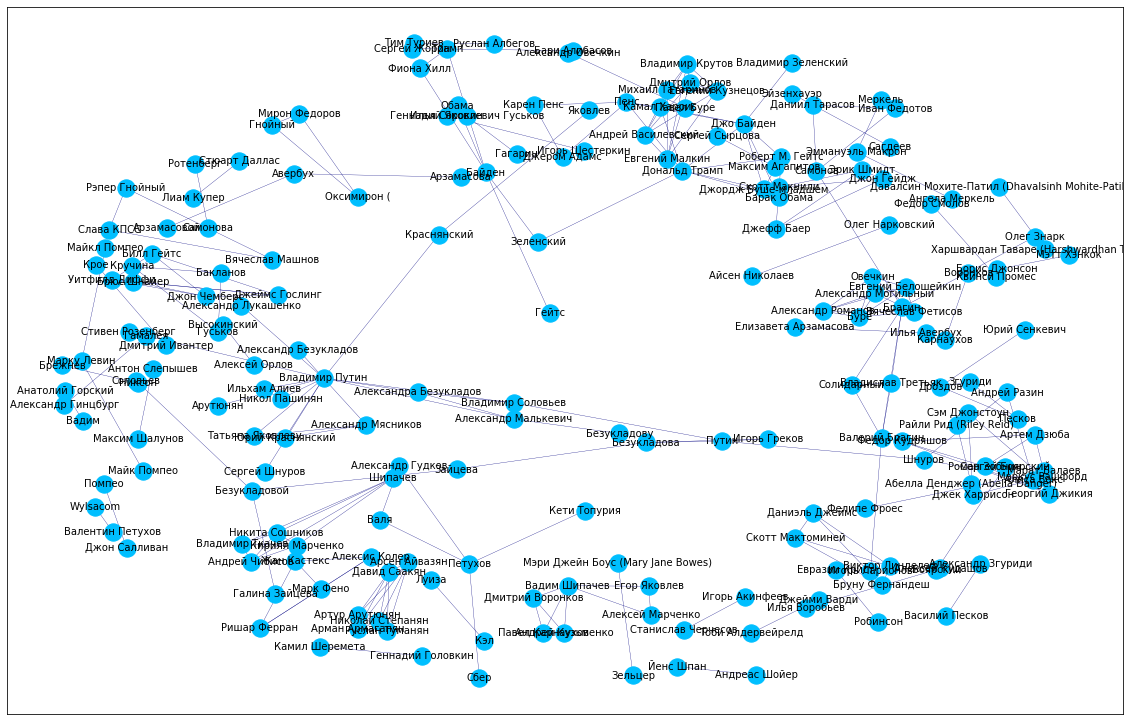

In [302]:
plt.figure(figsize=(20,13))
coord = nx.spring_layout(G, k = 0.30)
labs = nx.draw_networkx_labels(G,coord,labels,font_size=10)
nodes = nx.draw_networkx_nodes(G, label = labels, nodelist = nodes_list, pos = coord, node_size = 300, node_color = "#00BFFF")
edges = nx.draw_networkx_edges(G, edgelist = edges_list, pos = coord, width = .3, edge_color = "#000080")

##### Таким образом мы видим, что в целом личности распределены логичено, и мы можем выделить кластеры по сфере деятельности этих личностей

#### Строим модельку phraser

In [ ]:
sentences = Text8Corpus(datapath("data_test_text.txt"))
# Each sentence must be a list of string tokens:
first_sentence = next(iter(sentences))
print(first_sentence[:10])

In [ ]:
phrase_model = Phrases(sentences, min_count=1, threshold=1)

#### Возможно community detection позволит увидеть интересные связи

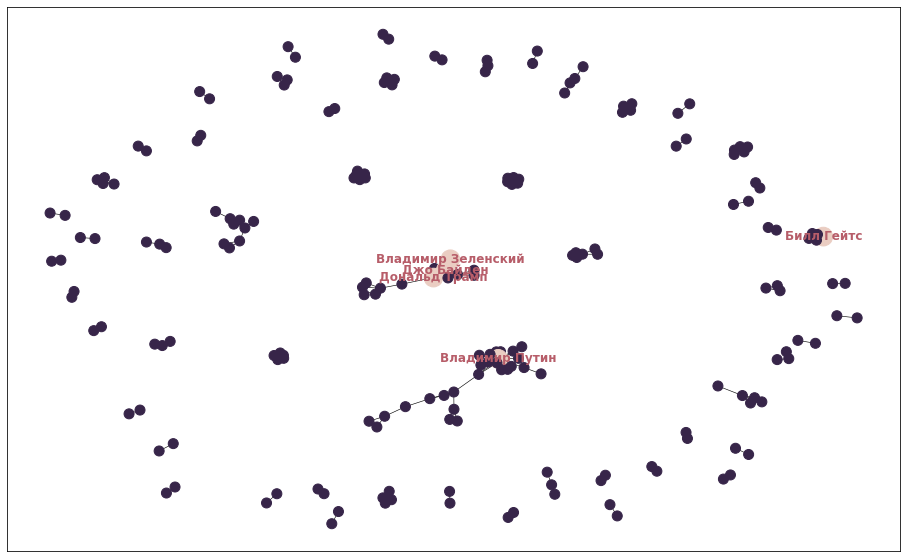

In [338]:
plt.figure(figsize=(16, 10))
seeds = [
    'Дональд Трамп',
    'Владимир Путин', 
    'Алексей Навальный', 
    'Джо Байден',
    'Билл Гейтс',
    'Владимир Зеленский'

]

pos = nx.spring_layout(G)

colorMap = []
sizes = []
labels = {}
for node in G:
    if node in seeds:
        colorMap.append('#EACDC2')
        sizes.append(350)
        labels[node] = node
    else: 
        colorMap.append('#372549')
        sizes.append(100)
        
nx.draw_networkx(G, pos=pos, labels=labels, node_color=colorMap, node_size=sizes, width=0.6, font_color = '#B75D69', font_weight='bold')

In [306]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities

In [337]:
import random
def showCommunities(G, communities, name):
    pos=nx.spring_layout(G)
    plt.figure(figsize=(16, 10))
    plt.title(name, fontsize=20)
    aux = 0
    number_of_colors = len(communities)
    curColor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    for community in communities:
        sizes =[350  if node in seeds else 100 for node in community]
        nx.draw_networkx_nodes(G, pos, community, node_size = sizes, node_color = curColor[aux])
        nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='r')
        aux = aux + 1
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show(block=True)

In [336]:
# def getModularityCommunities(G):
#     communities = community.greedy_modularity_communities(G)
#     return sorted(map(sorted, communities))

def getLabelPropagationCommunities(G):
    communities = label_propagation_communities(G)
    return sorted(map(sorted, communities))

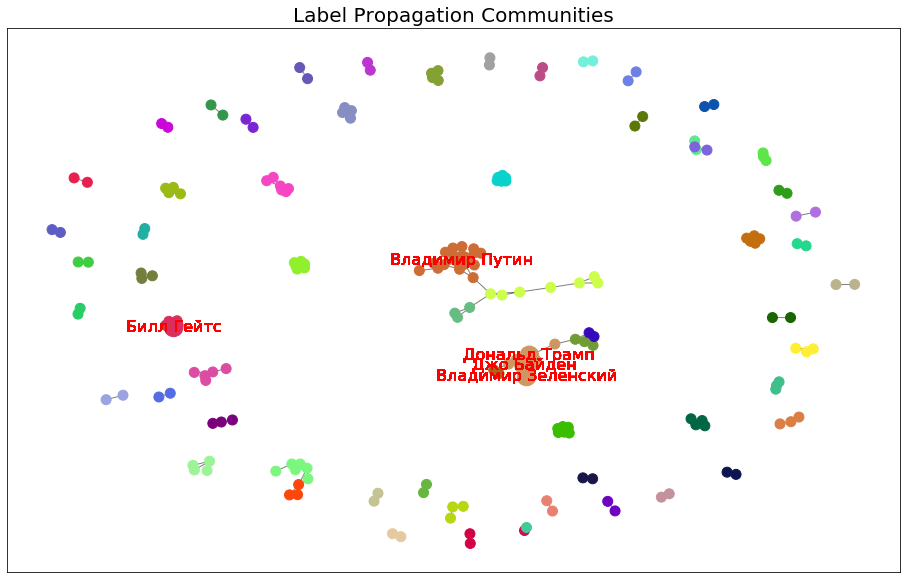

In [343]:
names = [
    'Label Propagation Communities'
]

methods = [
    getLabelPropagationCommunities,
]

for i in range(len(methods)):
    result = methods[i](G)
    showCommunities(G, result, name=names[i])